### Code

In [27]:
import pandas as pd
import random
import math


import glob

import numpy as np
import scipy as sp
import scipy.io

import matplotlib.pyplot as plt
from scipy.signal import find_peaks



def sum_err_mat(pr_errors, confidence_est):
   
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def BandpassFilter(signal, fs):
    '''Bandpass filter the signal between 40 and 240 BPM'''
    
    # Convert to Hz
    lo, hi = 40/60, 240/60
    
    b, a = sp.signal.butter(3, (lo, hi), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)



def Calc_percent_error():

    PPG_datas, ECG_datas = PPGECG_load() # load data
    errs, confs = [], []
    Fs = 125
    winShift = 2*Fs
    for PPG_data, ECG_data in list(zip(PPG_datas, ECG_datas))[:]: # get data in dataset.
        
        Fs = 125
    
        ppg, accx, accy, accz = Preprocessing_d(PPG_data) #preprocesssing data

        winSize = 16*Fs # Ground truth BPM provided in 16 second windows
        winShift = 2*Fs # Successive ground truth windows overlap by 2 seconds

        ref = sp.io.loadmat(ECG_data)

        errs = []
        confs = []

        # For each 8 second window, compute a predicted BPM and confidence and compare to ground truth
        offset = 0
        for windows_index in range(len(ref['BPM0'])):

          

            window_start = offset
            window_end = winSize+offset
            offset += winShift

      

            ppg_window = ppg[window_start:window_end]
            accx_window = accx[window_start:window_end]
            accy_window = accy[window_start:window_end]
            accz_window = accz[window_start:window_end]

            pred, conf = Filter_analyse(ppg_window, accx_window, accy_window, accz_window, Fs=Fs, verbose=verbose)

            groundTruthBPM = ref['BPM0'][windows_index][0]
  

            predError = groundTruthBPM - pred
            errs.append(predError)
            confs.append(conf)

            errors, confidence = np.array(errs), np.array(confs)
        errs.append(errors)
        confs.append(confidence)
            
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return (sum_err_mat(errs, confs))/winShift*Fs
def PPGECG_load():
   
    data_dir = "./datasets"
    PPG_datas = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ECG_datas = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return PPG_datas, ECG_datas

def Preprocessing_d(PPG_data):
  
    data = sp.io.loadmat(PPG_data)['sig']
    return data[2:]


def pdff(PPG_data, ECG_data):
    '''Given a sample data file with PPG and 3 accelerometer channels and reference file with ground truth heart rates,
       compute pulse rates every two seconds.
       Parameters:
           PPG_data: .mat file containing PPG and X, Y, Z accelerometer data from Troika dataset
           ECG_data: .mat file containing ground truth heart rates from Troika dataset
       
       Returns:
           errors: numpy array with differences between predicted and reference heart rates
           confidence: numpy array with confidence values for heart rate predictions
    '''
    # Load data using Preprocessing_d
    
    Fs = 135 # Troika data has sampling rate of 125 Hz
    
    ppg, accx, accy, accz = Preprocessing_d(PPG_data)
    
    winSize = 16*Fs # 
    winShift = 2*Fs # 
    
    ref = sp.io.loadmat(ECG_data)
    
    errs = []
    confs = []
    
    # For each 8 second window, compute a predicted BPM and confidence and compare to ground truth
    offset = 0
    for windows_index in range(len(ref['BPM0'])):
        
        # Set verbose to True to visualize plot analysis
        verbose = False
        # verbose = True if windows_index == 28 else False
    
        window_start = offset
        window_end = winSize+offset
        offset += winShift
        
        if verbose:
            print(f"Win start,end: {window_start}, {window_end}")
        
        ppg_window = ppg[window_start:window_end]
        accx_window = accx[window_start:window_end]
        accy_window = accy[window_start:window_end]
        accz_window = accz[window_start:window_end]

        pred, conf = Filter_analyse(ppg_window, accx_window, accy_window, accz_window, Fs=Fs, verbose=verbose)
        
        groundTruthBPM = ref['BPM0'][windows_index][0]
        if verbose:
            print('Ground Truth BPM: ', groundTruthBPM)

        predError = groundTruthBPM - pred
        errs.append(predError)
        confs.append(conf)

    errors, confidence = np.array(errs), np.array(confs)
    return errors, confidence


def Filter_analyse(ppg, accx, accy, accz, Fs=125, verbose=False):
    ''' Analyze a single 8 second window of PPG and Accelerometer data.
        Parameters:
            ppg: numpy array with ppg values
            accx/y/z: numpy arrays with per-axis accelerometer data
            Fs: sampling rate used by both PPG and accelerometer sensors
            verbose: display plots and logging information.
    
        Returns:
            prediction: Tuple of (BPM prediction, confidence) for this window.
    '''
    
    ppg_bandpass = BandpassFilter(ppg, fs=Fs)
    accx_bandpass = BandpassFilter(accx, fs=Fs)
    accy_bandpass = BandpassFilter(accy, fs=Fs)
    accz_bandpass = BandpassFilter(accz, fs=Fs)
    
    # Aggregate accelerometer data into single signal
    
    accy_mean = accy-np.mean(accy_bandpass) # Center Y values
    acc_mag_unfiltered = np.sqrt(accx_bandpass**2+accy_mean**2+accz_bandpass**2)
    acc_mag = BandpassFilter(acc_mag_unfiltered, fs=Fs)
    
    peaks = find_peaks(ppg_bandpass, height = 10, distance=35)[0]
    
    if verbose:
       None
        
    # Use FFT length larger than the input signal size for higher spectral resolution.
    fft_len=len(ppg_bandpass)*4

    # Create an array of frequency bins
    freqs = np.fft.rfftfreq(fft_len, 1 / Fs) # bins of width 0.12207031

    # The frequencies between 40 BPM and 240 BPM Hz
    low_freqs = (freqs >= (40/60)) & (freqs <= (240/60))
    
    mag_freq_ppg, fft_ppg = FreqTransform(ppg_bandpass, freqs, low_freqs, fft_len)
    mag_freq_acc, fft_acc = FreqTransform(acc_mag, freqs, low_freqs, fft_len)
    
    peaks_ppg = find_peaks(mag_freq_ppg, height=30, distance=1)[0]
    peaks_acc = find_peaks(mag_freq_acc, height=30, distance=1)[0]
    
    # Sort peaks in order of peak magnitude
    sorted_freq_peaks_ppg = sorted(peaks_ppg, key=lambda i:mag_freq_ppg[i], reverse=True)
    sorted_freq_peaks_acc = sorted(peaks_acc, key=lambda i:mag_freq_acc[i], reverse=True)
    
    # Use the frequency peak with the highest magnitude, unless the peak is also present in the accelerometer peaks.
    use_peak = sorted_freq_peaks_ppg[0]
    for i in range(len(sorted_freq_peaks_ppg)):
        # Check nearest two peaks also
        cond1 = sorted_freq_peaks_ppg[i] in sorted_freq_peaks_acc
        cond2 = sorted_freq_peaks_ppg[i]-1 in sorted_freq_peaks_acc
        cond3 = sorted_freq_peaks_ppg[i]+1 in sorted_freq_peaks_acc
        if cond1 or cond2 or cond3:
            continue
        else:
            use_peak = sorted_freq_peaks_ppg[i]
            break

    chosen_freq = freqs[low_freqs][use_peak]
    prediction = chosen_freq * 60
    confidence = CalcConfidence(chosen_freq, freqs, fft_ppg)
    
    if verbose:
        plt.title("PPG Frequency Magnitude")
        plt.plot(mag_freq_ppg)
        plt.plot(peaks_ppg, mag_freq_ppg[peaks_ppg], "x")
        plt.show()
        
        plt.title("Filtered Magnitude")
        plt.plot(mag_freq_acc, color="purple")
        plt.plot(peaks_acc, mag_freq_acc[peaks_acc], "x")
        plt.show()
        
        print("PPG Freq Peaks: ", peaks_ppg)
        print("ACC Freq Peaks: ", peaks_acc)
        
        print("PPG Freq Peaks Sorted: ", sorted_freq_peaks_ppg)
        print("ACC Freq Peaks Sorted: ", sorted_freq_peaks_acc)
        print("Use peak: ", use_peak)
        print(f"Predicted BPM: {prediction}, {chosen_freq} (Hz), Confidence: {confidence}")        
        
    return (prediction, confidence)

def BandpassFilter(signal, fs):
    '''Bandpass filter the signal between 40 and 240 BPM'''
    
    # Convert to Hz
    lo, hi = 40/60, 240/60
    
    b, a = sp.signal.butter(3, (lo, hi), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def FreqTransform(x, freqs, low_freqs, fft_len):
    '''Compute and return FFT and magnitude of FFT for given low frequencies
        Parameters:
            x: numpy array input signal to transform
            freqs: full list of FFT frequency bins
            low_freqs: low frequency bins between 40 BPM and 240 BPM
            fft_len: length of FFT to compute
            
        Returns:
            mag_freq_x: magnitude of lower frequencies of the FFT transformed signal
            fft_x: FFT of normalized input signal
    '''
    
    # Take an FFT of the normalized signal
    norm_x = (x - np.mean(x))/(max(x)-min(x))
    fft_x = np.fft.rfft(norm_x, fft_len)

    # Calculate magnitude of the lower frequencies
    mag_freq_x = np.abs(fft_x)[low_freqs]
    
    return mag_freq_x, fft_x

def CalcConfidence(chosen_freq, freqs, fft_ppg):
    '''Calculates a confidence value for a given frequency by computing
       the ratio of energy concentrated near that frequency compared to the full signal.
       Parameters:
           chosen_freq: frequency prediction for heart rate.
           freqs: full list of FFT frequency bins
           fft_ppg: FFT of normalized PPG signal
       
       Returns:
           conf_val: Confidence value for heart rate prediction.
    '''
    win = (40/60.0)
    win_freqs = (freqs >= chosen_freq - win) & (freqs <= chosen_freq + win)
    abs_fft_ppg = np.abs(fft_ppg)
    
    # Sum frequency spectrum near pulse rate estimate and divide by sum of entire spectrum
    conf_val = np.sum(abs_fft_ppg[win_freqs])/np.sum(abs_fft_ppg)
    
    return conf_val

Win start,end: 5500, 6500


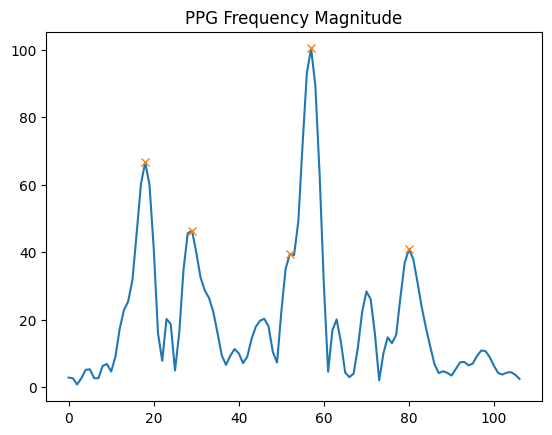

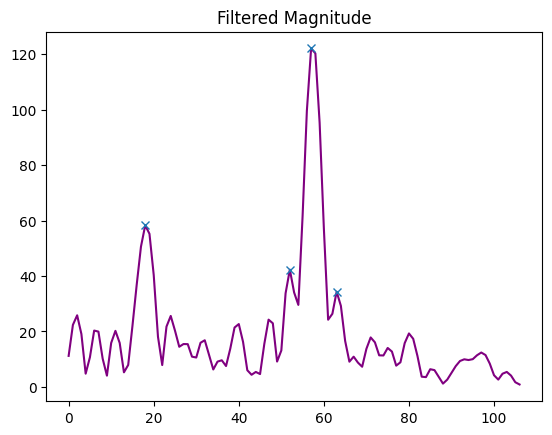

PPG Freq Peaks:  [18 29 52 57 80]
ACC Freq Peaks:  [18 52 57 63]
PPG Freq Peaks Sorted:  [57, 18, 29, 80, 52]
ACC Freq Peaks Sorted:  [57, 18, 52, 63]
Use peak:  29
Predicted BPM: 95.625, 1.59375 (Hz), Confidence: 0.4089426238641458
Ground Truth BPM:  96.35974304068522
Prediction Error:  0.7347430406852169
=====
 absolute_per_error is:  9.482193550281817  %


In [28]:
# Single Window Test

PPG_datas, ECG_datas = PPGECG_load()

# CHOOSE FILE
file_num = 1

PPG_data, ECG_data = list(zip(PPG_datas, ECG_datas))[file_num:file_num+1][0]

# Load data using Preprocessing_d
Fs = 125 # Troika data has sampling rate of 125 Hz
ppg, accx, accy, accz = Preprocessing_d(PPG_data)
ref = sp.io.loadmat(ECG_data)

winSize = 8*Fs # Ground truth BPM provided in 8 second windows
winShift = 2*Fs # Successive ground truth windows overlap by 2 seconds

# CHOOSE WINDOW IN FILE
windows_index = 22

offset = windows_index*winShift

window_start = offset
window_end = winSize+offset
offset += winShift

print(f"Win start,end: {window_start}, {window_end}")
ppg_window = ppg[window_start:window_end]

accx_window = accx[window_start:window_end]
accy_window = accy[window_start:window_end]
accz_window = accz[window_start:window_end]

pred, conf = Filter_analyse(ppg_window, accx_window, accy_window, accz_window, Fs=Fs, verbose=True)

groundTruthBPM = ref['BPM0'][windows_index][0]
print('Ground Truth BPM: ', groundTruthBPM)

predError = groundTruthBPM - pred
print("Prediction Error: ", predError)

absolute_per_error = Calc_percent_error()
print("=====\n", "absolute_per_error is: ", absolute_per_error, " %")